In [41]:
from gurobipy import *
from gurobipy import GRB
import math

In [42]:
m = Model("Modelo Proyecto")

In [43]:
edges = [
    [14, 13, 7.50, 10.00],
    [13, 12, 8.00, 11.00],
    [13, 11, 9.00, 18.00],
    [11, 10, 4.00, 4.00],
    [14, 9, 11.00, 11.00],
    [9, 8, 8.00, 11.00],
    [9, 7, 11.00, 11.00],
    [8, 6, 11.00, 11.00],
    [8, 5, 8.00, 11.00],
    [14, 4, 11.00, 11.00],
    [4, 3, 9.00, 12.00],
    [4, 2, 8.00, 11.00],
    [2, 1, 4.00, 4.00],
    [12, 6, 4.00, 4.00],
    [7, 3, 4.00, 4.00],
    [10, 1, 9.00, 12.00]
]

nodes = [
    [14, 0.0, 0.0, 0.0],
    [13, 2000.0, 1600.0, 0.0],
    [12, 3000.0, 1500.0, 1100.0],
    [11, 2000.0, 800.0, 1200.0],
    [10, 1500.0, 1200.0, 0.0],
    [9, 4000.0, 2700.0, 0.0],
    [8, 5000.0, 3000.0, 1200.0],
    [7, 1000.0, 900.0, 0.0],
    [6, 600.0, 100.0, 600.0],
    [5, 4500.0, 2000.0, 3700.0],
    [4, 1000.0, 900.0, 0.0],
    [3, 1000.0, 700.0, 1800.0],
    [2, 1000.0, 900.0, 0.0],
    [1, 2100.0, 1000.0, 1800.0]
]

In [44]:
# Sets

N = [node[0] for node in nodes]
E = [(edge[0], edge[1]) for edge in edges]


In [45]:
# Parametros

nref = 14
vref = 1
vbase = 23
sbase = 100000
tol = 10**-8
vmin = 0.93
vmax = 1.05
zbase = 100


R = {(edge[0], edge[1]): (edge[2]/100)*zbase for edge in edges}
X = {(edge[0], edge[1]): (edge[3]/100)*zbase for edge in edges}
Z = {(edge[0], edge[1]): math.sqrt((edge[2]/100)*zbase + (edge[3]/100)*zbase) for edge in edges}
minV = vmin*vbase
maxV = vmax*vbase
refV = vref*vbase

# Falta por saber
Imax = {(edge[0], edge[1]): 10000 for edge in edges}

Pd = {node[0]: node[1] for node in nodes}
Qd = {node[0]: node[2] for node in nodes}
Qbc = {node[0]: node[3] for node in nodes}
deltaS = {}
deltaV = {}
mS = 0
n = len(N)
s = 5
w = 5

b = 100

In [46]:
# Variables Proyecto

Pg = m.addVars(N, vtype=GRB.CONTINUOUS, name="Pg")
Qg = m.addVars(N, vtype=GRB.CONTINUOUS, name="Qg")
P = m.addVars(E, vtype=GRB.CONTINUOUS, name="P")
Q = m.addVars(E, vtype=GRB.CONTINUOUS, name="Q")
V = m.addVars(N, vtype=GRB.CONTINUOUS, name="V")
I = m.addVars(E, vtype=GRB.CONTINUOUS, name="I")
deltaV = m.addVars(E, vtype=GRB.CONTINUOUS, lb=float('-inf'), name="deltaV")
y = m.addVars(E, vtype=GRB.BINARY, name="y")

In [47]:
# Funcion objetivo

m.setObjective(quicksum(R[edge] * I[edge] for edge in E), GRB.MINIMIZE)

In [48]:
# Restricciones Proyecto
for node in N:
    m.addConstr(quicksum(P[edge] for edge in E if edge[1] == node) - quicksum(P[edge] + R[edge]*I[edge] for edge in E if edge[0] == node) + Pg[node] == Pd[node])
    m.addConstr(quicksum(Q[edge] for edge in E if edge[1] == node) - quicksum(Q[edge] + X[edge]*I[edge] for edge in E if edge[0] == node) + Qg[node] == Qd[node])

for edge in E:
    m.addConstr(V[edge[0]] == V[edge[1]] + 2*(R[edge]*P[edge] + X[edge]*Q[edge]) + Z[edge]**2*I[edge] + deltaV[edge])
    m.addConstr(-b*(1-y[edge]) <= deltaV[edge])
    m.addConstr(deltaV[edge] <= b*(1-y[edge]))
    m.addConstr(V[edge[0]]*I[edge] == P[edge]**2 + Q[edge]**2)

for node in N:
    m.addConstr(minV**2 <= V[node])
    m.addConstr(V[node] <= maxV**2)
    m.addConstr(I[edge] <= Imax[edge]*y[edge])
    
m.addConstr(quicksum(y[edge] for edge in E) == n - 1)

# for node in N:
#     if node != nref:
#         m.addConstr(Pg[node] == 0)
#         m.addConstr(Qg[node] == 0)        

<gurobi.Constr *Awaiting Model Update*>

In [49]:
m.setParam(GRB.Param.NonConvex, 2)
m.setParam(GRB.Param.FeasibilityTol, tol)
m.optimize()

Set parameter NonConvex to value 2
Set parameter FeasibilityTol to value 1e-08
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-7700T CPU @ 2.90GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 119 rows, 122 columns and 356 nonzeros
Model fingerprint: 0x5600bcc4
Model has 16 quadratic constraints
Variable types: 106 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [4e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 5e+03]
Presolve removed 69 rows and 28 columns
Presolve time: 0.00s
Presolved: 226 rows, 142 columns, 546 nonzeros
Presolved model has 48 bilinear constraint(s)
Variable types: 126 continuous, 16 integer (16 binary)

Root relaxation: objective 0.000000e+00, 28 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current No

In [12]:
# Variables Paper

Pg = m.addVars(N, vtype=GRB.CONTINUOUS, name="Pg")
Qg = m.addVars(N, vtype=GRB.CONTINUOUS, name="Qg")
P = m.addVars(E, vtype=GRB.CONTINUOUS, name="P")
Q = m.addVars(E, vtype=GRB.CONTINUOUS, name="Q")
V = m.addVars(N, vtype=GRB.CONTINUOUS, name="V")
I = m.addVars(E, vtype=GRB.CONTINUOUS, name="I")
Ppos = m.addVars(E, vtype=GRB.CONTINUOUS, name="Ppos")
Pneg = m.addVars(E, vtype=GRB.CONTINUOUS, name="Pneg")
Qpos = m.addVars(E, vtype=GRB.CONTINUOUS, name="Qpos")
Pneg = m.addVars(E, vtype=GRB.CONTINUOUS, name="Pneg")
ypos = m.addVars(E, vtype=GRB.BINARY, name="ypos")
yneg = m.addVars(E, vtype=GRB.BINARY, name="yneg")
x = m.addVars(N, vtype=GRB.BINARY, name="x")
deltaP = m.addVars(E, vtype=GRB.CONTINUOUS, name="deltaP")
deltaQ = m.addVars(E, vtype=GRB.CONTINUOUS, name="deltaQ")
a = m.addVars(E, vtype=GRB.CONTINUOUS, name="a")
Pc = m.addVars(E, vtype=GRB.CONTINUOUS, name="Pc")

deltaV = m.addVars(E, vtype=GRB.CONTINUOUS, lb=float('-inf'), name="deltaV")
y = m.addVars(E, vtype=GRB.BINARY, name="y")

In [13]:
# Restricciones Paper

for node in N:
    m.addConstr(quicksum(P[edge] for edge in E if edge[1] == node) - quicksum(P[edge] + R[edge]*I[edge] for edge in E if edge[1] == node) + Pg[node] == Pd[node])
    m.addConstr(quicksum(Q[edge] for edge in E if edge[1] == node) - quicksum(Q[edge] + X[edge]*I[edge] for edge in E if edge[1] == node) + Qg[node] == Qd[node])

for edge in E:
    m.addConstr(V[edge[0]] - 2*(R[edge]*P[edge] + X[edge]*Q[edge]) - Z[edge]**2*I[edge] - V[edge[1]] - a[edge] == 0)
    m.addConstr(V[edge[0]]*I[edge] == P[edge]**2 + Q[edge]**2)

for node in N:
    m.addConstr(minV**2 <= V[node])
    m.addConstr(V[node] <= maxV**2)
    
for edge in E:
    m.addConstr(I[edge] <= Imax[edge]**2*(ypos[edge] + yneg[edge]))
    m.addConstr(Ppos[edge] - Pneg[edge] == P[edge])
    m.addConstr(Ppos[edge] <= maxV*Imax[edge]*ypos[edge])
    m.addConstr(Pneg[edge] <= maxV*Imax[edge]*yneg[edge])
    m.addConstr(-maxV*Imax[edge]*(ypos[edge] + yneg[edge]) <= Q[edge])
    m.addConstr(Q[edge] <= maxV*Imax[edge]*(ypos[edge] + yneg[edge]))
    m.addConstr(a[edge] <= (maxV**2-minV**2)*(1-(ypos[edge] + yneg[edge])))

m.addConstr(quicksum(ypos[edge] + yneg[edge] for edge in E) == n - 1)
for edge in E:
    m.addConstr(ypos[edge] + yneg[edge] <= 1)
    m.addConstr(ypos[edge] <= 1)
    m.addConstr(yneg[edge] <= 1)    

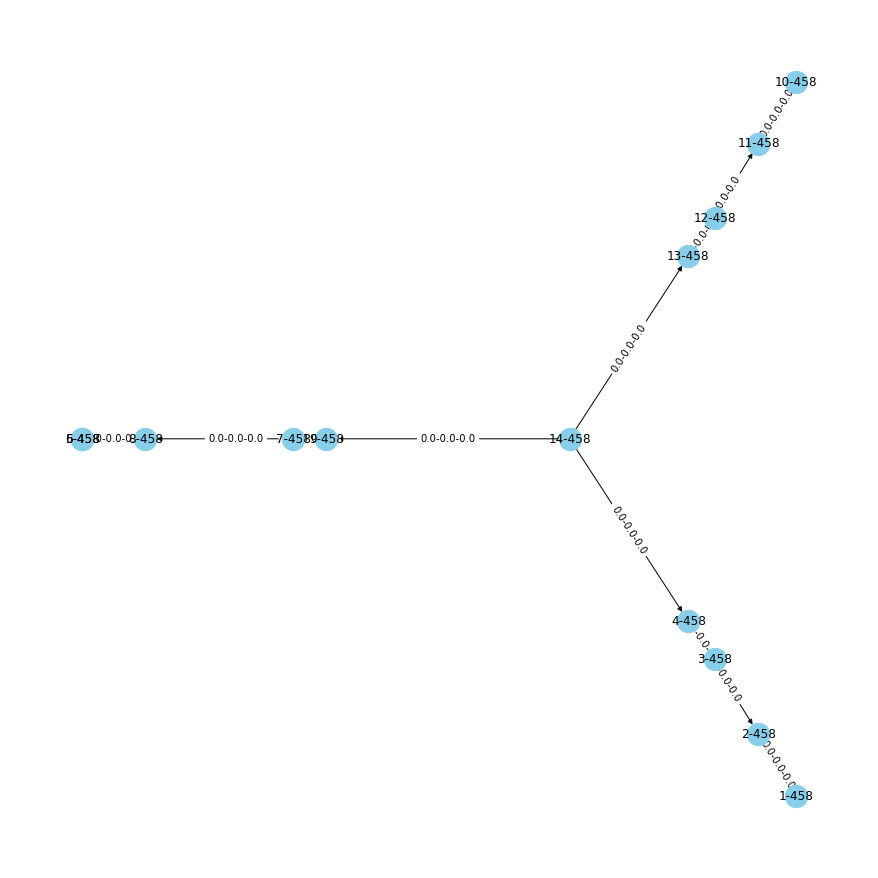

In [127]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

active_edges = [edge for edge in E if m.getVarByName(f'y[{edge[0]},{edge[1]}]').X == 1]
G.add_nodes_from(N)
G.add_edges_from(active_edges)

pos = nx.spectral_layout(G)
plt.figure(3,figsize=(12,12)) 
nx.draw(G, node_size=500, node_color="skyblue", pos=pos)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={edge: str(m.getVarByName(f'P[{edge[0]},{edge[1]}]').X) +"-"+ str(m.getVarByName(f'Q[{edge[0]},{edge[1]}]').X) + "-" + str(m.getVarByName(f'I[{edge[0]},{edge[1]}]').X) for edge in active_edges}
)
nx.draw_networkx_labels(G, pos, {node: str(node) + "-" + str(round(m.getVarByName(f'V[{node}]').X)) for node in N})
plt.show()